In [ ]:
'''
TODO

hook up get_pixel_vectors()
hook up get_field_vectors()

search for optimal hyperparams
''';

# NFL Helmet Tracker

Using field coordinates (in yards) for all 22 players and N<22 players' helmet positions (in pixels) , can we predict all players' positions?

### Field Coordinates for all players (from sensor)
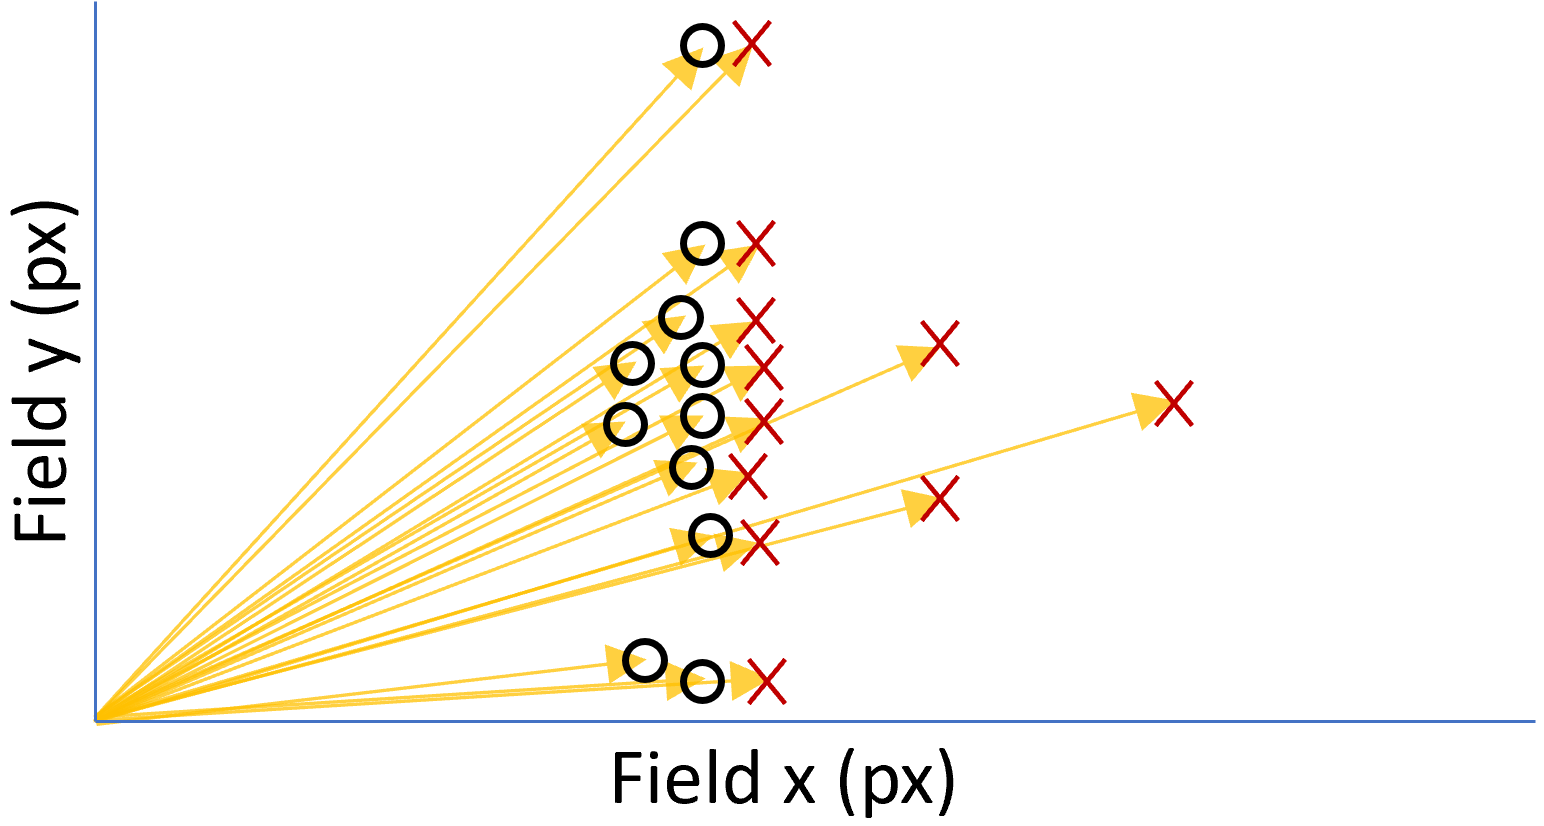

### Pixel Coordinates for a subset of players
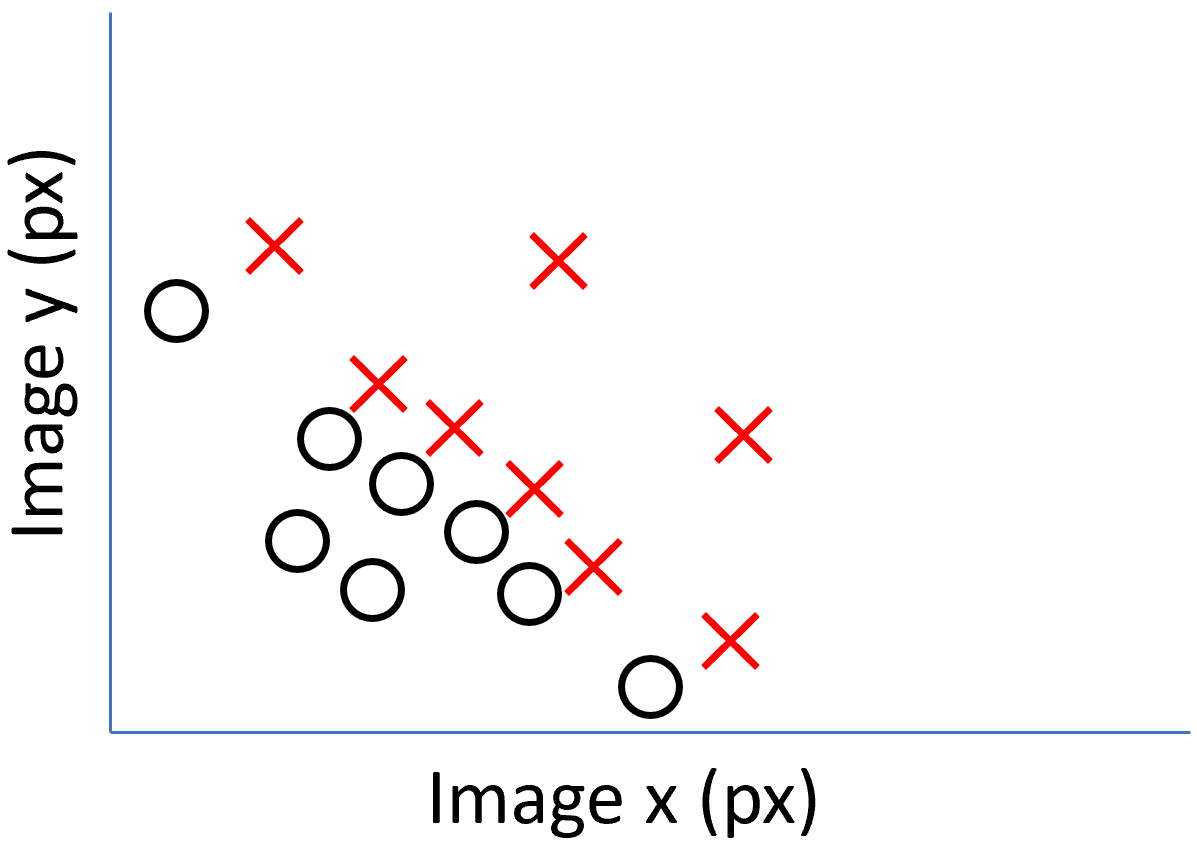

### Goal: find remaining players' pixel coordinates
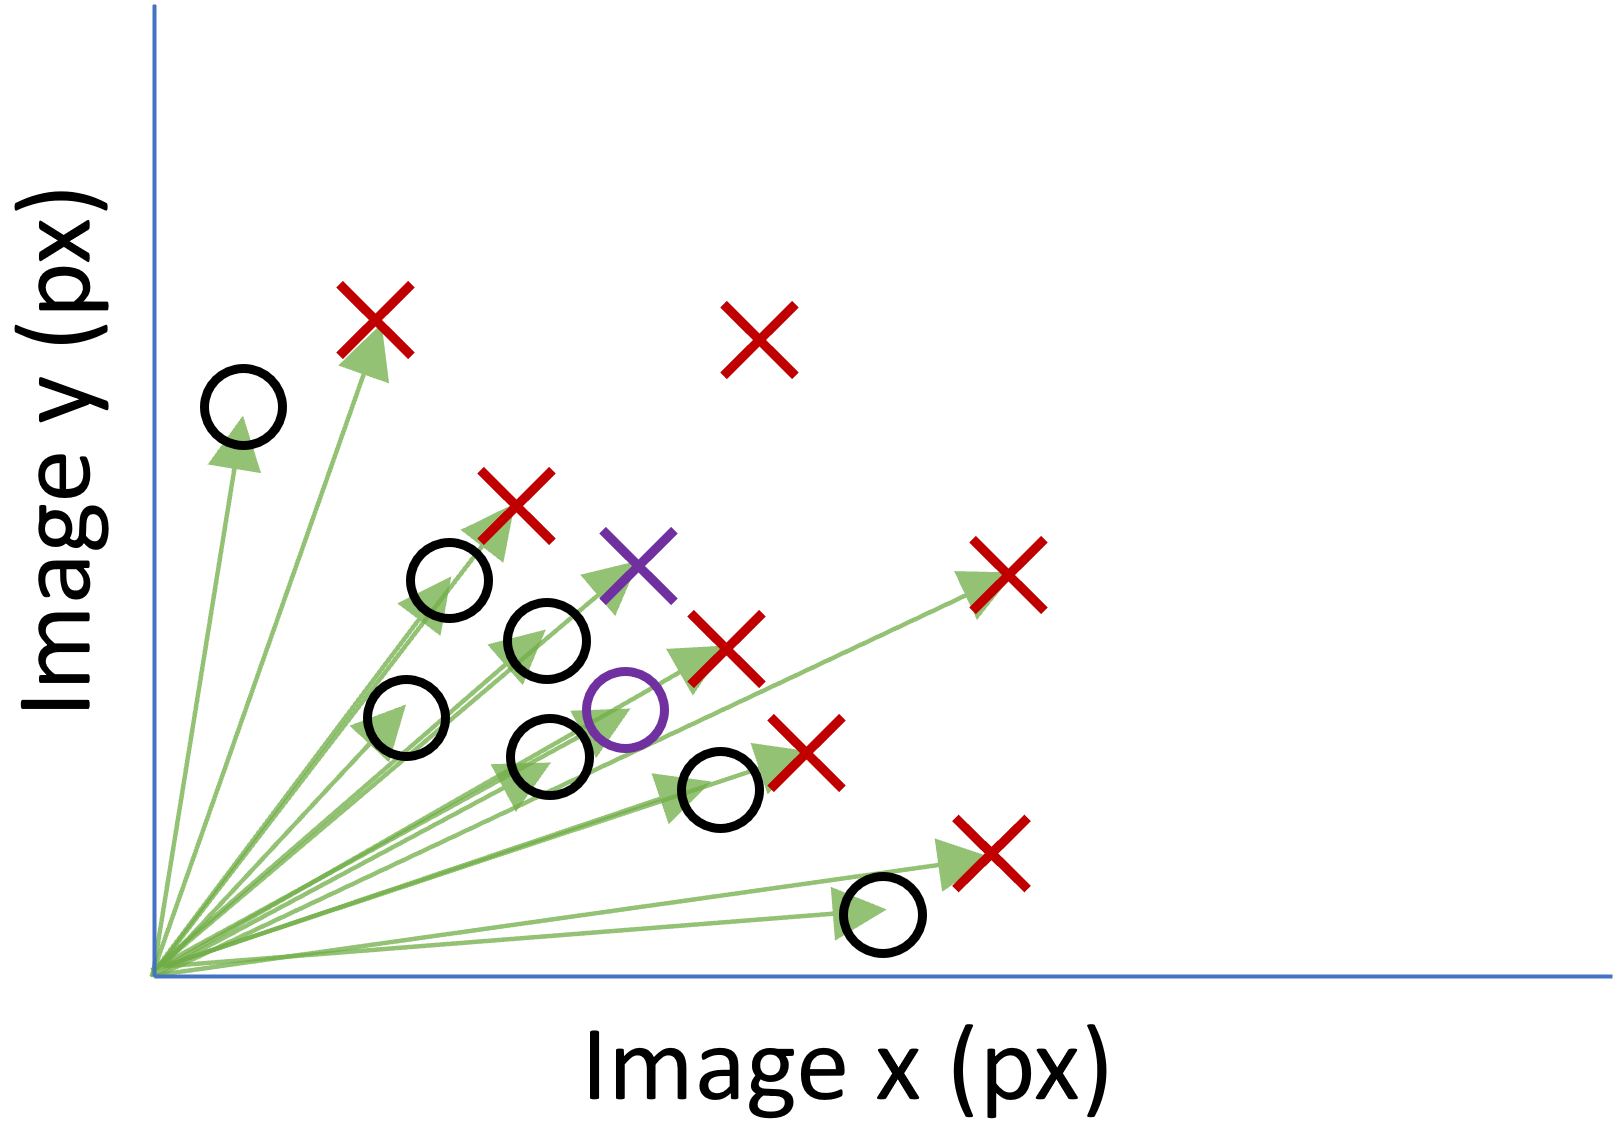

##Key  
N number of identified helmets  
$P_1$ (P1) [2 by N matrix]: base helmets in pixels space  
$F1$ (F1) [2 by 22 matrix]: tracked positions in field space  
$P2'$ (P2_prime) [2 by 22 matrix]: tracked helmets in pixel space (estimated)  
$\hat{P1}$ (P1_hat) [2 by N matrix]: estimates of the P1 using a subset of P2'  
$P2$ P2 [2 by 22 matrix]: estimates of all 22 helmets in pixel space

## Code

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import queue

In [ ]:
%matplotlib inline

In [ ]:
# Hyperparameters
weight = 0.5 # weight toward Euclidean similarity, 0 = no weight, 0.5 = equal, 1 = all
alpha = 0.01 # learning rate
N_EPOCHS = 500

In [ ]:
# from 57783_003374_Endzone_1, has 17 players on field, 16 w/ helmet identified
def get_pixel_vectors():
  return np.array([[701., 228., 505.5, 1063., 253., 826., 564., 683., 323., 370.5, 765.5, 630., 963.5, 445., 59.5, 900.],
                   [293., 319.5, 278.5, 276.5, 266., 298., 296., 459., 301., 115., 282., 113., 301., 294., 160., 128.]])

#                   H74   H15     H12     H78   H62   H73     H25     H81   H14   H56     H72     V98   V38     V90   V31     V57   V54     V96     V99   V24     V25   V55
def get_field_vectors():
  return np.array([[47.43, 47.76, 47.56, 46.61, 47.49, 46.95, 54.31, 48.07, 48.2 , 47.24, 47.32, 45.56, 41.29, 45.48, 42.94, 42.05, 41.04, 45.37, 45.44, 44.54, 30.49, 40.55],
                   [20.5 , 43.8 , 23.74, 23.73, 18.94, 25.29, 23.5 , 17.77, 34.87, 22.07, 27.05, 17.95, 19.33, 28.49, 15.24, 34.3 , 26.3 , 21.17, 24.78, 43.89, 26.79, 22.81]])

In [ ]:
P1 = torch.tensor(get_pixel_vectors())
F1 = torch.tensor(get_field_vectors())
P1.shape, F1.shape

(torch.Size([2, 16]), torch.Size([2, 22]))

In [ ]:
P1_R = torch.tensor([[ 0,1],
                     [-1,0]], dtype=torch.float64)@P1 # rotate 90 degree clockwise
P1_R = torch.tensor([[1,0],
                     [ 0,-1]], dtype=torch.float64)@P1_R # reflect on the x axis

In [ ]:
from matplotlib.pyplot import figure

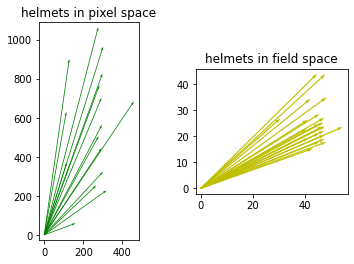

In [ ]:
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R[0,:]), torch.zeros_like(P1_R[1,:]), 
           P1_R[0,:] , P1_R[1,:], scale_units='xy', scale=1, angles='xy', color='g')
plt.xlim(min(P1_R[0,:].min(),0)-25, P1_R[0,:].max()+25)
plt.ylim(min(P1_R[1,:].min(),0)-25, P1_R[1,:].max()+25)
plt.title('helmets in pixel space')

plt.subplot(1, 2, 2, aspect='equal')
plt.quiver(torch.zeros_like(F1[0,:]), torch.zeros_like(F1[1,:]), 
           F1[0,:] , F1[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(F1[0,:].min(),0)-2, F1[0,:].max()+2)
plt.ylim(min(F1[1,:].min(),0)-2, F1[1,:].max()+2)
plt.title('helmets in field space');

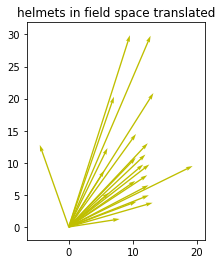

In [ ]:
F1_tr = F1 + torch.tensor([[-35],
                           [-14]], dtype=torch.float64) # translate the origin of the field space
plt.subplot(1, 1, 1, aspect='equal')
plt.quiver(torch.zeros_like(F1_tr[0,:]), torch.zeros_like(F1_tr[1,:]), 
           F1_tr[0,:] , F1_tr[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(F1_tr[0,:].min(),0)-2, F1_tr[0,:].max()+2)
plt.ylim(min(F1_tr[1,:].min(),0)-2, F1_tr[1,:].max()+2)
plt.title('helmets in field space translated');

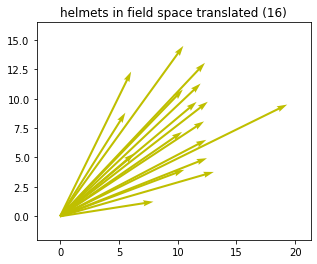

In [ ]:
F1_tr = F1 + torch.tensor([[-35],
                           [-14]], dtype=torch.float64)
# print(F1_tr)
idx = torch.where((F1_tr[1]<20) & (F1_tr[0] > 0)) # ignore the very large vectors or vectors with x < 0
# print(idx)
F1_tr = torch.index_select(F1_tr, 1, idx[0])
plt.subplot(1, 1, 1, aspect='equal')
plt.quiver(torch.zeros_like(F1_tr[0,:]), torch.zeros_like(F1_tr[1,:]), 
           F1_tr[0,:] , F1_tr[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(F1_tr[0,:].min(),0)-2, F1_tr[0,:].max()+2)
plt.ylim(min(F1_tr[1,:].min(),0)-2, F1_tr[1,:].max()+2)
plt.title('helmets in field space translated (16)');

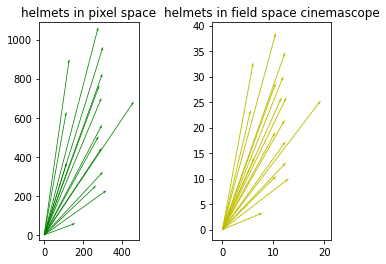

In [ ]:
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R[0,:]), torch.zeros_like(P1_R[1,:]), 
           P1_R[0,:] , P1_R[1,:], scale_units='xy', scale=1, angles='xy', color='g')
plt.xlim(min(P1_R[0,:].min(),0)-25, P1_R[0,:].max()+25)
plt.ylim(min(P1_R[1,:].min(),0)-25, P1_R[1,:].max()+25)
plt.title('helmets in pixel space')
F1_cs = torch.tensor([[1, 0],
                      [0, 2.667]], dtype=torch.float64)@F1_tr # cinemascope
plt.subplot(1, 2, 2, aspect='equal')
plt.quiver(torch.zeros_like(F1_cs[0,:]), torch.zeros_like(F1_tr[1,:]), 
           F1_cs[0,:] , F1_cs[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(F1_cs[0,:].min(),0)-2, F1_cs[0,:].max()+2)
plt.ylim(min(F1_cs[1,:].min(),0)-2, F1_cs[1,:].max()+2)
plt.title('helmets in field space cinemascope');

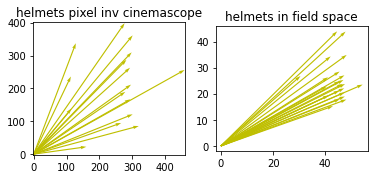

In [ ]:
P1_R_inv = torch.tensor([[1, 0],
                         [0, 1/2.667]], dtype=torch.float64)@P1_R # reverse cinemascope
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R_inv[0,:]), torch.zeros_like(P1_R_inv[1,:]), 
           P1_R_inv[0,:] , P1_R_inv[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(P1_R_inv[0,:].min(),0)-2, P1_R_inv[0,:].max()+2)
plt.ylim(min(P1_R_inv[1,:].min(),0)-2, P1_R_inv[1,:].max()+2)
plt.title('helmets pixel inv cinemascope');

plt.subplot(1, 2, 2, aspect='equal')
plt.quiver(torch.zeros_like(F1[0,:]), torch.zeros_like(F1[1,:]), 
           F1[0,:] , F1[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(F1[0,:].min(),0)-2, F1[0,:].max()+2)
plt.ylim(min(F1[1,:].min(),0)-2, F1[1,:].max()+2)
plt.title('helmets in field space');

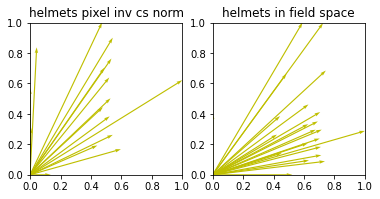

In [127]:
def norm_arr(a):
    a = a-a.min()
    a = a/a.max()
    return a
P1_R_inv_norm_x = norm_arr(P1_R_inv[0])
P1_R_inv_norm_y = norm_arr(P1_R_inv[1])
P1_R_inv_norm = torch.stack([P1_R_inv_norm_x, P1_R_inv_norm_y])
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R_inv_norm[0,:]), torch.zeros_like(P1_R_inv_norm[1,:]), 
           P1_R_inv_norm[0,:] , P1_R_inv_norm[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(0,1)
plt.ylim(0,1)
# plt.xlim(min(P1_R_inv_norm[0,:].min(),0)-2, P1_R_inv_norm[0,:].max()+2)
# plt.ylim(min(P1_R_inv_norm[1,:].min(),0)-2, P1_R_inv_norm[1,:].max()+2)
plt.title('helmets pixel inv cs norm');

F1_norm_x = norm_arr(F1[0])
F1_norm_y = norm_arr(F1[1])
F1_norm = torch.stack([F1_norm_x, F1_norm_y])    
plt.subplot(1, 2, 2, aspect='equal')
plt.quiver(torch.zeros_like(F1_norm[0,:]), torch.zeros_like(F1_norm[1,:]), 
           F1_norm[0,:] , F1_norm[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('helmets in field space');

torch.Size([2, 16]) torch.Size([2, 17])
tensor([[0.5202, 0.5968, 0.4783, 0.4725, 0.4422, 0.5347, 0.5289, 1.0000, 0.5434,
         0.0058, 0.4884, 0.0000, 0.5434, 0.5231, 0.1358, 0.0434],
        [0.6393, 0.1679, 0.4444, 1.0000, 0.1928, 0.7638, 0.5027, 0.6213, 0.2626,
         0.3099, 0.7035, 0.5685, 0.9008, 0.3842, 0.0000, 0.8376]],
       dtype=torch.float64)

tensor([[0.5000, 0.5094, 0.4404, 0.5044, 0.4651, 1.0000, 0.5465, 0.4862, 0.4920,
         0.3641, 0.0538, 0.3583, 0.1737, 0.0356, 0.3503, 0.3554, 0.0000],
        [0.3970, 0.6415, 0.6408, 0.2792, 0.7585, 0.6234, 0.1909, 0.5155, 0.8913,
         0.2045, 0.3087, 1.0000, 0.0000, 0.8347, 0.4475, 0.7200, 0.5713]],
       dtype=torch.float64)


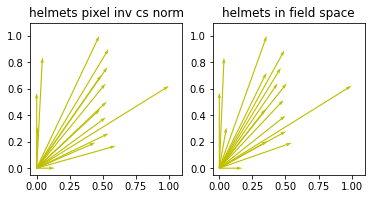

In [141]:
idx = torch.where((F1[1]<30) & (F1[0] > 35))
F1_sel = torch.index_select(F1, 1, idx[0])
print(P1_R_inv_norm.shape, F1_sel.shape)
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R_inv_norm[0,:]), torch.zeros_like(P1_R_inv_norm[1,:]), 
           P1_R_inv_norm[0,:] , P1_R_inv_norm[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)
# plt.xlim(min(P1_R_inv_norm[0,:].min(),0)-2, P1_R_inv_norm[0,:].max()+2)
# plt.ylim(min(P1_R_inv_norm[1,:].min(),0)-2, P1_R_inv_norm[1,:].max()+2)
plt.title('helmets pixel inv cs norm');
print(P1_R_inv_norm)
print()

F1_norm_x = norm_arr(F1_sel[0])
F1_norm_y = norm_arr(F1_sel[1])
F1_norm = torch.stack([F1_norm_x, F1_norm_y])    
print(F1_norm)
plt.subplot(1, 2, 2, aspect='equal')
plt.quiver(torch.zeros_like(F1_norm[0,:]), torch.zeros_like(F1_norm[1,:]), 
           F1_norm[0,:] , F1_norm[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)
plt.title('helmets in field space');

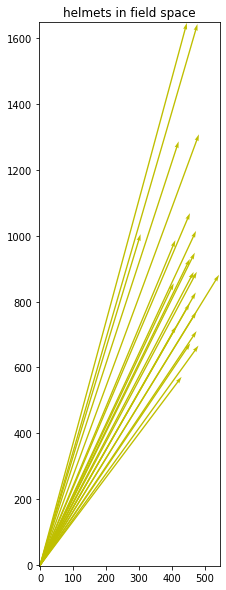

In [ ]:
M = torch.tensor([[10,0],
                  [ 0,1050/28]], dtype=torch.float64)
P2_prime = M@F1
plt.figure(figsize=(8,10))
plt.subplot(1, 1, 1, aspect='equal')
plt.quiver(torch.zeros_like(P2_prime[0,:]), torch.zeros_like(P2_prime[1,:]), 
           P2_prime[0,:] , P2_prime[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(P2_prime[0,:].min(),0)-2, P2_prime[0,:].max()+2)
plt.ylim(min(P2_prime[1,:].min(),0)-2, P2_prime[1,:].max()+2)
plt.title('helmets in field space');

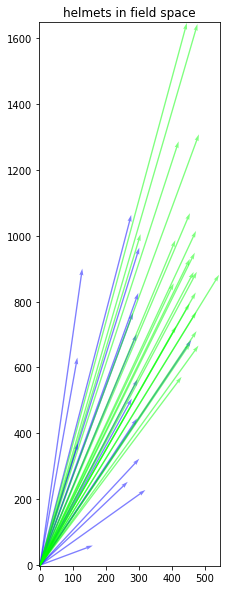

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R[0,:]), torch.zeros_like(P1_R[1,:]), 
           P1_R[0,:] , P1_R[1,:], scale_units='xy', scale=1, angles='xy', color=(0,0,1,0.5))
plt.xlim(min(P1_R[0,:].min(),0)-25, P1_R[0,:].max()+25)
plt.ylim(min(P1_R[1,:].min(),0)-25, P1_R[1,:].max()+25)
plt.title('helmets in pixel space')

plt.quiver(torch.zeros_like(P2_prime[0,:]), torch.zeros_like(P2_prime[1,:]), 
           P2_prime[0,:] , P2_prime[1,:], scale_units='xy', scale=1, angles='xy', color=(0,1,0,0.5))
plt.xlim(min(P2_prime[0,:].min(),0)-2, P2_prime[0,:].max()+2)
plt.ylim(min(P2_prime[1,:].min(),0)-2, P2_prime[1,:].max()+2)
plt.title('helmets in field space');

In [ ]:
weight = 0
# find the Euclidean distance from all known helmets in px space to P2'
EucDist = torch.zeros(size=(N, 22))
for px_vec_index in range(N):
  for est_vec_index in range(22):
    EucDist[px_vec_index][est_vec_index] = \
      torch.norm(P1_R[:,px_vec_index]-P2_prime[:,est_vec_index])
EucSim = 1-EucDist/torch.max(EucDist) # Similar vectors have 0 distance, largest diff has 1 distance
                                      # from link 1
                                      # TODO cap max at median/ HYPER_PARAM %ile to reduce effect of clearly wrong distances
# Find cosine similarity from all known helmets in px space to P2'
CosSim = torch.zeros(size=(N, 22))
for px_vec_index in range(N):
  for est_vec_index in range(22):
    CosSim[px_vec_index][est_vec_index] = \
      torch.cosine_similarity(P1_R[:,px_vec_index],P2_prime[:,est_vec_index],dim=0)
# Combine the similarity metrics
Sim = weight*EucDist + (1-weight)*CosSim
# Find subset of P2' that matches P1 best
matches = gale_shapely_algo_weights(Sim)
match_indices = [0]*N
for field_idx, img_idx in matches.items():
  match_indices[img_idx] = field_idx
P1_hat = P2_prime[:, match_indices]

In [ ]:
matches

{0: 1,
 1: 11,
 2: 2,
 3: 6,
 4: 7,
 6: 14,
 7: 4,
 8: 10,
 10: 15,
 11: 13,
 13: 5,
 14: 8,
 15: 12,
 16: 0,
 19: 3,
 20: 9}

In [ ]:
P1_R[:,1], P2_prime[:,0]

(tensor([319.5000, 228.0000], dtype=torch.float64),
 tensor([474.3000, 768.7500], dtype=torch.float64))

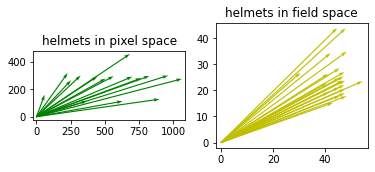

In [ ]:
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1_R[0,:]), torch.zeros_like(P1_R[1,:]), 
           P1_R[0,:] , P1_R[1,:], scale_units='xy', scale=1, angles='xy', color='g')
plt.xlim(min(P1_R[0,:].min(),0)-25, P1_R[0,:].max()+25)
plt.ylim(min(P1_R[1,:].min(),0)-25, P1_R[1,:].max()+25)
plt.title('helmets in pixel space')

plt.subplot(1, 2, 2, aspect='equal')
plt.quiver(torch.zeros_like(F1[0,:]), torch.zeros_like(F1[1,:]), 
           F1[0,:] , F1[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(F1[0,:].min(),0)-2, F1[0,:].max()+2)
plt.ylim(min(F1[1,:].min(),0)-2, F1[1,:].max()+2)
plt.title('helmets in field space');

The Matching Algorithm was originally introduced in 1962 paper *College Admissions and the Stability of Marriage* by Gale and Shapely  
Code adapted from [Wiki page on Gale Shapely Algo](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm)

In [ ]:
def gale_shapely_algo_weights(weights):
  '''
  weights N by 22 matrix
    each element weights[r][c] in the row is the similarity
      between vector r in img space and c in transformed field space

  Gale Shapely Algorithm
  init N free_img_vectors
  init N-vector most_recent_prop_rank
  init pairs {field_vectors : img_vectos}
  while there exists free_img_vec in free_img_vectors
    free_img_vec = free_img_vectors.pop()
    candidate_field_vec = most_recent_prop_rank[free_img_vec] highest column index in weights[free_img_vec]
    if candidate_field_vec not in pairs
      pairs[candidate_field_vec] = free_img_vec
    else
      competing_img_vec = pairs[candidate_field_vec]
      if weights[free_img_vec][candidate_field_vec] > weights[competing_img_vec][candidate_field_vec]
        add competing_img_vec to free_img_vectors
        most_recent_prop_rank[competing_img_vec]++
        pairs[candidate_field_vec] = free_img_vec
      else
        add free_img_vec to free_img_vectors
        most_recent_prop_rank[free_img_vec]++
  '''
  N = weights.shape[0]

  if weights.shape[1] != 22:
    print(weights.shape[1], ' players tracked != 22')
    return None

  free_img_vectors = queue.Queue()
  for i in range(weights.shape[0]):
    free_img_vectors.put(i)
  most_recent_prop_rank = [0]*weights.shape[0]
  pairs={}

  while not free_img_vectors.empty():
    free_img_vec = free_img_vectors.get()
    candidate_field_vec = torch.kthvalue(weights[free_img_vec], 22-most_recent_prop_rank[free_img_vec]).indices.item()
    if candidate_field_vec not in pairs:
      pairs[candidate_field_vec] = free_img_vec
    else:
      competing_img_vec = pairs[candidate_field_vec]
      if weights[free_img_vec][candidate_field_vec] > weights[competing_img_vec][candidate_field_vec]:
        free_img_vectors.put(competing_img_vec)
        most_recent_prop_rank[competing_img_vec] += 1
        pairs[candidate_field_vec] = free_img_vec
      else:
        free_img_vectors.put(free_img_vec)
        most_recent_prop_rank[free_img_vec] += 1
  return pairs

### Transformation Matrix

In [ ]:
torch.random.manual_seed(0) # TODO remove seed
M = torch.randn((2,2), requires_grad=True, dtype=torch.float64)
M

tensor([[ 1.5410, -0.2934],
        [-2.1788,  0.5684]], dtype=torch.float64, requires_grad=True)

In [ ]:
N_EPOCHS = 100
errors = np.zeros((N_EPOCHS,))

In [ ]:
# ADAM hyperparams
beta1 = 0.9
beta2 = 0.999
v_dM = torch.zeros_like(M)
s_dM = torch.zeros_like(M)
epsilon = 1.0e-8

In [ ]:
N = P1.shape[1]
assert F1.shape[1] == 22

for epoch in range(N_EPOCHS):
  M.requires_grad_(True)
  # convert 22 field coords to 22 candidate field coords
  P2_prime = M@F1
  # find the Euclidean distance from all known helmets in px space to P2'
  EucDist = torch.zeros(size=(N, 22))
  for px_vec_index in range(N):
    for est_vec_index in range(22):
      EucDist[px_vec_index][est_vec_index] = \
        torch.norm(P1[:,px_vec_index]-P2_prime[:,est_vec_index])
  EucSim = 1-EucDist/torch.max(EucDist) # Similar vectors have 0 distance, largest diff has 1 distance
                                        # from link 1
                                        # TODO cap max at median/ HYPER_PARAM %ile to reduce effect of clearly wrong distances
  # Find cosine similarity from all known helmets in px space to P2'
  CosSim = torch.zeros(size=(N, 22))
  for px_vec_index in range(N):
    for est_vec_index in range(22):
      CosSim[px_vec_index][est_vec_index] = \
        torch.cosine_similarity(P1[:,px_vec_index],P2_prime[:,est_vec_index],dim=0)
  # Combine the similarity metrics
  Sim = weight*EucDist + (1-weight)*CosSim
  # Find subset of P2' that matches P1 best
  matches = gale_shapely_algo_weights(Sim)
  match_indices = [0]*N
  for field_idx, img_idx in matches.items():
    match_indices[img_idx] = field_idx
  P1_hat = P2_prime[:, match_indices]
  # Find Loss and dLoss/dM
  Loss = sum((Sim[img_idx][field_idx] for field_idx, img_idx in matches.items()))
  # Loss = torch.linalg.norm(P1_hat-P1) # square error
  Loss.backward()
  errors[epoch] = Loss.detach().item()
  M.requires_grad_(False) # can't assign a variable in DAG to itself
  dM = M.grad
  # Update M with ADAM optimizer
  v_dM = beta1*v_dM + (1-beta1)*dM
  s_dM = beta2*s_dM + (1-beta2)*dM*dM
  v_denom = 1-beta1**(epoch+1) if epoch < 10 else 1
  s_denom = 1-beta2**(epoch+1) if epoch < 10 else 1
  M -= alpha*(v_dM)/np.sqrt(s_dM/(s_denom+epsilon))

In [ ]:
M

tensor([[5.9594, 3.8832],
        [3.3255, 6.0489]], dtype=torch.float64)

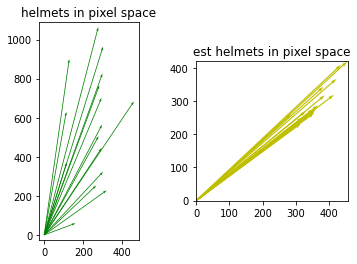

In [ ]:
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1[0,:]), torch.zeros_like(P1[1,:]), 
           P1[0,:] , P1[1,:], scale_units='xy', scale=1, angles='xy', color='g')
plt.xlim(min(P1[0,:].min(),0)-25, P1[0,:].max()+25)
plt.ylim(min(P1[1,:].min(),0)-25, P1[1,:].max()+25)
plt.title('helmets in pixel space')

plt.subplot(1, 2, 2, aspect='equal')
P1_hat = P1_hat.detach()
plt.quiver(torch.zeros_like(P1_hat[0,:]), torch.zeros_like(P1_hat[1,:]), 
           P1_hat[0,:] , P1_hat[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(P1_hat[0,:].min(),0)-2, P1_hat[0,:].max()+2)
plt.ylim(min(P1_hat[1,:].min(),0)-2, P1_hat[1,:].max()+2)
plt.title('est helmets in pixel space');

(2640.889892578125, 5236.310546875)

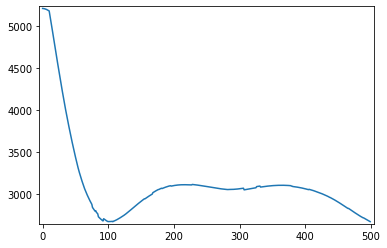

In [ ]:
plt.plot(list(range(N_EPOCHS)), errors)
plt.xlim(-5, N_EPOCHS+5)
plt.ylim(min(errors)-25, max(errors)+25)

### Affine Transform

In [ ]:
torch.random.manual_seed(0) # TODO remove seed
M = torch.randn((2,2), requires_grad=True, dtype=torch.float64)
b = torch.randn((2,1), requires_grad=True, dtype=torch.float64)
M, b

(tensor([[ 1.5410, -0.2934],
         [-2.1788,  0.5684]], dtype=torch.float64, requires_grad=True),
 tensor([[-1.0845],
         [-1.3986]], dtype=torch.float64, requires_grad=True))

In [ ]:
# ADAM hyperparams
beta1 = 0.9
beta2 = 0.999
v_dM = torch.zeros_like(M)
s_dM = torch.zeros_like(M)
v_db = torch.zeros_like(b)
s_db = torch.zeros_like(b)
epsilon = 1.0e-8

In [ ]:
errors = np.zeros((N_EPOCHS,))

In [ ]:
N = P1.shape[1]
assert F1.shape[1] == 22

for epoch in range(N_EPOCHS):
  M.requires_grad_(True)
  b.requires_grad_(True)
  # convert 22 field coords to 22 candidate field coords
  P2_prime = M@F1+b
  # find the Euclidean distance from all known helmets in px space to P2'
  EucDist = torch.zeros(size=(N, 22))
  for px_vec_index in range(N):
    for est_vec_index in range(22):
      EucDist[px_vec_index][est_vec_index] = \
        torch.norm(P1[:,px_vec_index]-P2_prime[:,est_vec_index])
  EucSim = 1-EucDist/torch.max(EucDist) # Similar vectors have 0 distance, largest diff has 1 distance
                                        # from link 1
                                        # TODO cap max at median/ HYPER_PARAM %ile to reduce effect of clearly wrong distances
  # Find cosine similarity from all known helmets in px space to P2'
  CosSim = torch.zeros(size=(N, 22))
  for px_vec_index in range(N):
    for est_vec_index in range(22):
      CosSim[px_vec_index][est_vec_index] = \
        torch.cosine_similarity(P1[:,px_vec_index],P2_prime[:,est_vec_index],dim=0)
  # Combine the similarity metrics
  Sim = weight*EucDist + (1-weight)*CosSim
  # Find subset of P2' that matches P1 best
  matches = gale_shapely_algo_weights(Sim)
  match_indices = [0]*N
  for field_idx, img_idx in matches.items():
    match_indices[img_idx] = field_idx
  P1_hat = P2_prime[:, match_indices]
  # Find Loss and dLoss/dM
  Loss = sum((Sim[img_idx][field_idx] for field_idx, img_idx in matches.items()))
  # Loss = torch.linalg.norm(P1_hat-P1) # square error
  Loss.backward()
  errors[epoch] = Loss.detach().item()
  M.requires_grad_(False) # can't assign a variable in DAG to itself
  b.requires_grad_(False)
  dM = M.grad
  db = b.grad
  # Update M with ADAM optimizer
  v_dM = beta1*v_dM + (1-beta1)*dM
  s_dM = beta2*s_dM + (1-beta2)*dM*dM
  v_denom = 1-beta1**(epoch+1) if epoch < 10 else 1
  s_denom = 1-beta2**(epoch+1) if epoch < 10 else 1
  M -= alpha*(v_dM)/np.sqrt(s_dM/(s_denom+epsilon))
  # Update b with ADAM optimizer
  v_db = beta1*v_db + (1-beta1)*db
  s_db = beta2*s_db + (1-beta2)*db*db
  b -= alpha*(v_db)/np.sqrt(s_db/(s_denom+epsilon))

In [ ]:
M, b

(tensor([[10.6078,  3.6417],
         [ 3.0433,  0.7118]], dtype=torch.float64), tensor([[10.1690],
         [ 3.6470]], dtype=torch.float64))

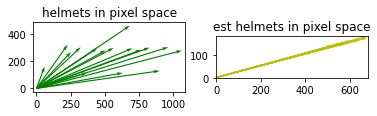

In [ ]:
plt.subplot(1, 2, 1, aspect='equal')
plt.quiver(torch.zeros_like(P1[0,:]), torch.zeros_like(P1[1,:]), 
           P1[0,:] , P1[1,:], scale_units='xy', scale=1, angles='xy', color='g')
plt.xlim(min(P1[0,:].min(),0)-25, P1[0,:].max()+25)
plt.ylim(min(P1[1,:].min(),0)-25, P1[1,:].max()+25)
plt.title('helmets in pixel space')

plt.subplot(1, 2, 2, aspect='equal')
P1_hat = P1_hat.detach()
plt.quiver(torch.zeros_like(P1_hat[0,:]), torch.zeros_like(P1_hat[1,:]), 
           P1_hat[0,:] , P1_hat[1,:], scale_units='xy', scale=1, angles='xy', color='y')
plt.xlim(min(P1_hat[0,:].min(),0)-2, P1_hat[0,:].max()+2)
plt.ylim(min(P1_hat[1,:].min(),0)-2, P1_hat[1,:].max()+2)
plt.title('est helmets in pixel space');

(2611.1611328125, 5249.12548828125)

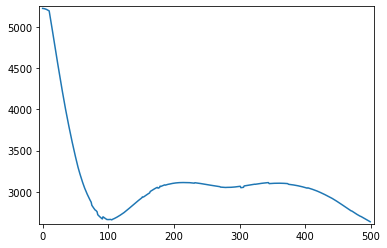

In [ ]:
plt.plot(list(range(N_EPOCHS)), errors)
plt.xlim(-5, N_EPOCHS+5)
plt.ylim(min(errors)-25, max(errors)+25)

## Matching Torch Module

## NOT USED! matching lib

In [ ]:
if False:
  !pip install matching
  import matching
  from matching import Player
  from matching.games import StableMarriage

  def gale_shapely_algo_ranks(weights):
    '''
    weights N by 22 matrix
      each element weights[r][c] in the row is the similarity
        between vector r in img space and c in transformed field space
    '''
    # init player objs
    img_vec_players = [Player(r) for r in range(weights.shape[0])]
    field_vec_players = [Player(c) for c in range(weights.shape[1])]
    # give img player objs preferences
    for r in range(weights.shape[0]):
      sorted_col = weights[r,:].flatten().argsort()
      pref_indices = [0]*sorted_col.shape[0]
      for i, rank in enumerate(sorted_col):
        pref_indices[rank] = i
      print('row',r ,len([field_vec_players[i] for i in pref_indices]))
      img_vec_players[r].set_prefs([field_vec_players[i] for i in pref_indices])
    # give field player obj preferences
    for c in range(weights.shape[1]):
      sorted_col = weights[:,c].flatten().argsort()
      pref_indices = [0]*sorted_col.shape[0]
      for i, rank in enumerate(sorted_col):
        pref_indices[rank] = i
      print('col', c, len([img_vec_players[i] for i in pref_indices]))
      field_vec_players[c].set_prefs([img_vec_players[i] for i in pref_indices])
    return StableMarriage(img_vec_players, field_vec_players).solve()